![Buffalo Soccer Header](https://carload.com/g/BuffaloSoccerWide400.jpg)

# Part 3, Fit Models to the Data

In Parts 1 and 2 of this process, I cleaned and wrangled Bundesliga match data from two sources. The result was a clean CSV file that contained, for each match, both teams' previous three weeks of performance. Another difficult factor was adding a note whether the teams had each played in a midweek game in the days before the match in question.

My Google Colab account has a much better GPU than my laptop at home, so with the data wrangled, it's time to turn to some work online.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
dfMaster = pd.read_csv('/content/drive/My Drive/master.csv')
dfMaster.head()

,Unnamed: 0,y,ordToday,homeToday,awayToday,MHOrd,MAOrd,MHLoc,MALoc,MHRes,...,AF_A3,HC_A3,AC_A3,HY_A3,AY_A3,HR_A3,AR_A3,AvgH_A3,AvgD_A3,AvgA_A3
0,0,1,738044,Freiburg,FC Koln,0,0,0,0,0,...,14,4,5,4,2,0,0,2.57,3.34,2.80
1,1,0,738044,Greuther Furth,Wolfsburg,0,0,0,0,0,...,7,5,2,0,2,0,1,1.57,4.37,5.63
2,2,0,738044,Hoffenheim,Mainz,0,0,0,0,0,...,8,5,11,1,2,0,0,8.07,5.44,1.35
3,3,0,738044,Leverkusen,Dortmund,0,0,0,0,0,...,14,7,3,0,0,0,0,1.44,5.17,6.49
4,4,1,738044,Union Berlin,Augsburg,0,0,0,0,0,...,9,6,5,1,2,0,0,3.19,3.68,2.17


Some kind of unnamed index field got added in the CSV process. That's easy to get rid of.

In [ ]:
dfMaster.drop(dfMaster.columns[0], axis=1, inplace=True)
dfMaster.head()

,y,ordToday,homeToday,awayToday,MHOrd,MAOrd,MHLoc,MALoc,MHRes,MARes,...,AF_A3,HC_A3,AC_A3,HY_A3,AY_A3,HR_A3,AR_A3,AvgH_A3,AvgD_A3,AvgA_A3
0,1,738044,Freiburg,FC Koln,0,0,0,0,0,0,...,14,4,5,4,2,0,0,2.57,3.34,2.80
1,0,738044,Greuther Furth,Wolfsburg,0,0,0,0,0,0,...,7,5,2,0,2,0,1,1.57,4.37,5.63
2,0,738044,Hoffenheim,Mainz,0,0,0,0,0,0,...,8,5,11,1,2,0,0,8.07,5.44,1.35
3,0,738044,Leverkusen,Dortmund,0,0,0,0,0,0,...,14,7,3,0,0,0,0,1.44,5.17,6.49
4,1,738044,Union Berlin,Augsburg,0,0,0,0,0,0,...,9,6,5,1,2,0,0,3.19,3.68,2.17


In [ ]:
# Setting some date constants
# We want Matchday 4-30 of each season for training
# and Matchday 31-34 for validation
# Constants represent first day of Matchday 4 & 31,
#  last day of Matchday 30. Only day of Matchday 34.

M4_2021  = 738044 # Sept. 11, 2021
M30_2021 = 738262 # April 17, 2022
M31_2021 = 738267 # April 22, 2022
M34_2021 = 738289 # May 14, 2022

M4_2022  = 738393 # Aug. 26, 2022
M30_2022 = 738640 # April 30, 2023
M31_2022 = 738645 # May 5, 2023
M34_2022 = 738667 # May 27, 2023

M4_2023  = 738778 # Sept. 15, 2023
M30_2023 = 738997 # April 21, 2024
M31_2023 = 739002 # April 26, 2024
M34_2023 = 739024 # May 18, 2024

In [ ]:
train21 = dfMaster[(dfMaster['ordToday'] >= M4_2021) & (dfMaster['ordToday'] <= M30_2021)]
print(train21.shape)
test21 = dfMaster[(dfMaster['ordToday'] >= M31_2021) & (dfMaster['ordToday'] <= M34_2021)]
print(test21.shape)
train22 = dfMaster[(dfMaster['ordToday'] >= M4_2022) & (dfMaster['ordToday'] <= M30_2022)]
print(train22.shape)
test22 = dfMaster[(dfMaster['ordToday'] >= M31_2022) & (dfMaster['ordToday'] <= M34_2022)]
print(test22.shape)
train23 = dfMaster[(dfMaster['ordToday'] >= M4_2023) & (dfMaster['ordToday'] <= M30_2023)]
print(train23.shape)
test23 = dfMaster[(dfMaster['ordToday'] >= M31_2023) & (dfMaster['ordToday'] <= M34_2023)]
print(test23.shape)

(243, 163)
(36, 163)
(243, 163)
(36, 163)
(243, 163)
(36, 163)


In [ ]:
dfTrain = pd.concat([train21, train22, train23])
print(dfTrain.shape)
dfTest = pd.concat([test21, test22, test23])
print(dfTest.shape)

(729, 163)
(108, 163)


Let's replace all the strings with index numbers so we can fit a model to the data.

In [ ]:
teamList = ('Augsburg', 'Bayern Munich', 'Bielefeld', 'Bochum', 'Darmstadt', 'Dortmund',
            'Ein Frankfurt', 'FC Koln', 'Freiburg', 'Greuther Furth', 'Heidenheim',
            'Hertha', 'Hoffenheim', 'Leverkusen', "M'gladbach", 'Mainz', 'RB Leipzig',
            'Schalke 04', 'Stuttgart', 'Union Berlin', 'Werder Bremen', 'Wolfsburg')

In [ ]:
for eachTeam in teamList:
  dfTrain.replace(eachTeam, teamList.index(eachTeam), inplace = True)
  dfTest.replace(eachTeam, teamList.index(eachTeam), inplace = True)

dfTrain.head()

<ipython-input-9-374372393e29>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfTrain.replace(eachTeam, teamList.index(eachTeam), inplace = True)
<ipython-input-9-374372393e29>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfTest.replace(eachTeam, teamList.index(eachTeam), inplace = True)


,y,ordToday,homeToday,awayToday,MHOrd,MAOrd,MHLoc,MALoc,MHRes,MARes,...,AF_A3,HC_A3,AC_A3,HY_A3,AY_A3,HR_A3,AR_A3,AvgH_A3,AvgD_A3,AvgA_A3
0,1,738044,8,7,0,0,0,0,0,0,...,14,4,5,4,2,0,0,2.57,3.34,2.80
1,0,738044,9,21,0,0,0,0,0,0,...,7,5,2,0,2,0,1,1.57,4.37,5.63
2,0,738044,12,15,0,0,0,0,0,0,...,8,5,11,1,2,0,0,8.07,5.44,1.35
3,0,738044,13,5,0,0,0,0,0,0,...,14,7,3,0,0,0,0,1.44,5.17,6.49
4,1,738044,19,0,0,0,0,0,0,0,...,9,6,5,1,2,0,0,3.19,3.68,2.17


I almost forgot these letters under full-time and half-time results. As is the case elsewhere in the dataset, 3 means a home win, 0 a visitor win, 1 apiece for a tie.

In [ ]:
dfTrain.replace('H', 3, inplace=True)
dfTrain.replace('D', 1, inplace=True)
dfTrain.replace('A', 0, inplace=True)
dfTest.replace('H', 3, inplace=True)
dfTest.replace('D', 1, inplace=True)
dfTest.replace('A', 0, inplace=True)
dfTrain.head()

<ipython-input-10-37a3f7b73bbd>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfTrain.replace('A', 0, inplace=True)
<ipython-input-10-37a3f7b73bbd>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfTest.replace('A', 0, inplace=True)


,y,ordToday,homeToday,awayToday,MHOrd,MAOrd,MHLoc,MALoc,MHRes,MARes,...,AF_A3,HC_A3,AC_A3,HY_A3,AY_A3,HR_A3,AR_A3,AvgH_A3,AvgD_A3,AvgA_A3
0,1,738044,8,7,0,0,0,0,0,0,...,14,4,5,4,2,0,0,2.57,3.34,2.80
1,0,738044,9,21,0,0,0,0,0,0,...,7,5,2,0,2,0,1,1.57,4.37,5.63
2,0,738044,12,15,0,0,0,0,0,0,...,8,5,11,1,2,0,0,8.07,5.44,1.35
3,0,738044,13,5,0,0,0,0,0,0,...,14,7,3,0,0,0,0,1.44,5.17,6.49
4,1,738044,19,0,0,0,0,0,0,0,...,9,6,5,1,2,0,0,3.19,3.68,2.17


## Build and Train the Model

Will a basic deep learning model be enough to do the trick?

One drawback was that the 'y' value result can be 0, 1, or 3. Keras doesn't like non-contiguous numeric targets, so I had to bump the number of classes up to four, though 2 should never be selected.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

x_train = dfTrain.drop('y', axis=1).values
y_train = dfTrain['y'].values
x_test = dfTest.drop('y', axis=1).values
y_test = dfTest['y'].values

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [ ]:
model = Sequential([
    Dense(128, input_shape=(x_train.shape[1],), activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

x_train = np.asarray(x_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

modResult = model.fit(x_train, y_train, epochs = 6, batch_size = 32,
                      validation_data = (x_test, y_test))

loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.3586 - loss: 66806.8594 - val_accuracy: 0.4722 - val_loss: 19367.5020
Epoch 2/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3586 - loss: 35706.0117 - val_accuracy: 0.4722 - val_loss: 13311.4385
Epoch 3/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3267 - loss: 22297.4766 - val_accuracy: 0.4722 - val_loss: 3680.4084
Epoch 4/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3945 - loss: 11751.4756 - val_accuracy: 0.4722 - val_loss: 2896.8701
Epoch 5/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3773 - loss: 6390.7852 - val_accuracy: 0.4722 - val_loss: 1402.9943
Epoch 6/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3428 - loss: 4189.7495 - val_accuracy: 0.4722 - val_loss: 225.1417
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4503 - loss: 228.7932 
Test Accuracy: 47.22%


I've spared some steps for you. Different numbers of epochs (not seen here) were typically unhelpful in improving the validation accuracy, although the loss kept going down, of course. Here's an example of that.

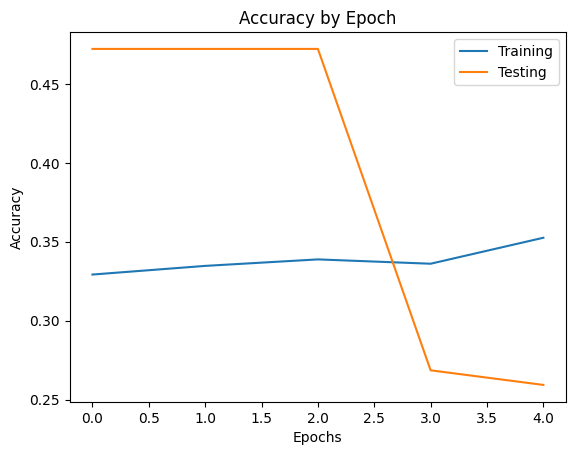

In [ ]:
#Plot Accuracy by Epoch
plt.plot(modResult.history['accuracy'], label = 'Training')
plt.plot(modResult.history['val_accuracy'], label = 'Testing')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy by Epoch')
plt.legend()
plt.show()


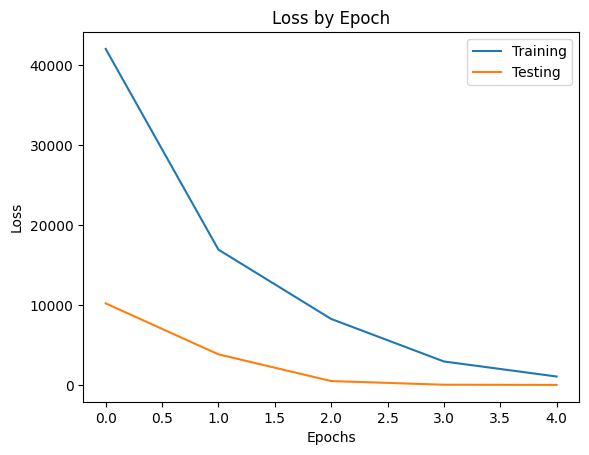

In [ ]:
#Plot Loss by Epoch
plt.plot(modResult.history['loss'], label = 'Training')
plt.plot(modResult.history['val_loss'], label = 'Testing')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss by Epoch')
plt.legend()
plt.show()


## Comparing the Model's Results to Bookkeepers'

The average bookkeeper odds that were included in the original data ought to be a decent proxy for the Poisson distribution projections that became popular over the past 5-10 years. When I checked them, I ran into the oddity that the percentages for the three possible outcomes always added up to 104.5%.

Example:
* Home Team Win 2.07 (1/2.07 = 48.3%)
* Draw 3.58 (1/3.58 = 27.9%)
* Away Team Win 3.53 (1/3.53 = 28.3%)

TOTAL 48.3 + 27.9 + 28.3 = 104.5%

I'd guess that this has to do with the bookkeepers' slice of all bets, but that's irrelevant for now. To compare the stated odds to what the model predicts, I'll multiply the book version by 0.957 to get them back to 100%.

In [ ]:
predArray = model.predict(x_test)
print(predArray[0])
print(y_test[0])

BOOK_ADJUST = 0.957  # Bookie dataset numbers add to 104.5% for each game. Weird!
homePct = (1 / dfTest.iloc[0]['AvgH']) * BOOK_ADJUST
drawPct = (1 / dfTest.iloc[0]['AvgD']) * BOOK_ADJUST
awayPct = (1 / dfTest.iloc[0]['AvgA']) * BOOK_ADJUST
print(homePct, drawPct, awayPct)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[2.887007e-12 0.000000e+00 0.000000e+00 1.000000e+00]
[0. 0. 0. 1.]
0.40723404255319146 0.28147058823529414 0.30477707006369426


### The Moment of Truth

Instead of judging the model based on how often its predictions are correct, I thought it would be more significant to compare them to the bookkeepers' odds. If the model's prediction of the correct outcome was a higher percentage, I awarded that match to the model. Otherwise, the bookkeeper won.

In [ ]:
modelWins = 0
bookWins = 0
modelTotal = 0
bookTotal = 0

arrayIndex = 0
for index, row in dfTest.iterrows():
    # Compute bookmakers' odds for the match
    homePct = (1 / row['AvgH'])
    drawPct = (1 / row['AvgH'])
    awayPct = (1 / row['AvgH'])

    modelHome = predArray[arrayIndex][0]
    modelDraw = predArray[arrayIndex][1]
    modelAway = predArray[arrayIndex][3]

    if y_test[arrayIndex][3] == 1:  # Home win
        if modelHome > homePct:
            modelWins += 1
            modelTotal += (modelHome - homePct)
        else:
            bookWins += 1
            bookTotal += (homePct - modelHome)

    if y_test[arrayIndex][1] == 1:  # Draw
        if modelDraw > drawPct:
            modelWins += 1
            modelTotal += (modelDraw - drawPct)
        else:
            bookWins += 1
            bookTotal += (drawPct - modelDraw)

    if y_test[arrayIndex][0] == 1:  # Away win
        if modelAway > awayPct:
            modelWins += 1
            modelTotal += (modelAway - awayPct)
        else:
            bookWins += 1
            bookTotal += (awayPct - modelAway)

    arrayIndex += 1

print(f"Model Wins: {modelWins}")
print(f"Bookie Wins: {bookWins}")
print(f"Model Total: {modelTotal}")
print(f"Bookie Total: {bookTotal}")


Model Wins: 29
Bookie Wins: 79
Model Total: 17.582834903234467
Bookie Total: 41.106283912956734


Well that's depressing. Despite tweaking the number of epochs (see below), I never had a better winning percentage than the bookkeepers.

A particularly annoying problem that popped up sometimes was the model giving a significant probability to the impossible result of 2. Maybe I can do something about that.

In [ ]:
# array below is zero-based, no epochs = no wins
# Trying 4 or 6 or 14 epochs is looking best so far
#   (51 v 57, Total difference 23.49 v 25.02)
# winsByEpoch = [0, 29, 28, 29, 51, 29, 51, 14, 14, 28, 14, 37, 29, 14, 51, 22, 29, 28, 18, 18, 18]
# 50 epochs = 29 wins. 200 epochs = 25 wins.

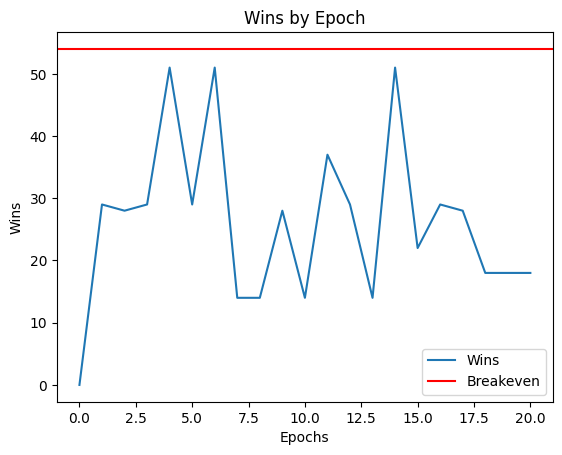

In [ ]:
#Plot wins by Epoch
winsByEpoch = [0, 29, 28, 29, 51, 29, 51, 14, 14, 28, 14, 37, 29, 14, 51, 22, 29, 28, 18, 18, 18]
plt.plot(winsByEpoch, label = 'Wins')
plt.axhline(y  =54, color = 'r', linestyle = '-', label = 'Breakeven')
plt.xlabel('Epochs')
plt.ylabel('Wins')
plt.title('Wins by Epoch')
plt.legend()
plt.show()


###Another Try
Maybe if I drop the soccer-centric match scoring of 3, 1, and 0, I could switch to the more logical 1, 0, and -1.

Let's see what happens when I replace 3, 1, 0 with 1, 0, -1 for each win-draw-loss column.

In [ ]:
dfAbsolute = dfMaster.copy(deep = True)

In [ ]:
dfAbsolute['y'] = dfAbsolute['y'].replace(0, -1)
dfAbsolute['y'] = dfAbsolute['y'].replace(1, 0)
dfAbsolute['y'] = dfAbsolute['y'].replace(3, 1)
dfAbsolute.head()

,y,ordToday,homeToday,awayToday,MHOrd,MAOrd,MHLoc,MALoc,MHRes,MARes,...,AF_A3,HC_A3,AC_A3,HY_A3,AY_A3,HR_A3,AR_A3,AvgH_A3,AvgD_A3,AvgA_A3
0,0,738044,Freiburg,FC Koln,0,0,0,0,0,0,...,14,4,5,4,2,0,0,2.57,3.34,2.80
1,-1,738044,Greuther Furth,Wolfsburg,0,0,0,0,0,0,...,7,5,2,0,2,0,1,1.57,4.37,5.63
2,-1,738044,Hoffenheim,Mainz,0,0,0,0,0,0,...,8,5,11,1,2,0,0,8.07,5.44,1.35
3,-1,738044,Leverkusen,Dortmund,0,0,0,0,0,0,...,14,7,3,0,0,0,0,1.44,5.17,6.49
4,0,738044,Union Berlin,Augsburg,0,0,0,0,0,0,...,9,6,5,1,2,0,0,3.19,3.68,2.17


In [ ]:
dfAbsolute['MHRes'] = np.where(((dfAbsolute['MHOrd'] == 1) & (dfAbsolute['MHRes'] == 0)), -1, dfAbsolute['MHRes'])

In [ ]:
dfAbsolute['MHRes'] = np.where(((dfAbsolute['MHOrd'] == 1) & (dfAbsolute['MHRes'] == 1)), 0, dfAbsolute['MHRes'])
dfAbsolute['MHRes'] = np.where(((dfAbsolute['MHOrd'] == 1) & (dfAbsolute['MHRes'] == 3)), 1, dfAbsolute['MHRes'])

In [ ]:
dfAbsolute['MARes'] = np.where(((dfAbsolute['MAOrd'] == 1) & (dfAbsolute['MARes'] == 0)), -1, dfAbsolute['MARes'])
dfAbsolute['MARes'] = np.where(((dfAbsolute['MAOrd'] == 1) & (dfAbsolute['MARes'] == 1)), 0, dfAbsolute['MARes'])
dfAbsolute['MARes'] = np.where(((dfAbsolute['MAOrd'] == 1) & (dfAbsolute['MARes'] == 3)), 1, dfAbsolute['MARes'])

In [ ]:
dfAbsolute['y_H1'] = dfAbsolute['y_H1'].replace(0, -1)
dfAbsolute['y_H1'] = dfAbsolute['y_H1'].replace(1, 0)
dfAbsolute['y_H1'] = dfAbsolute['y_H1'].replace(3, 1)
dfAbsolute['y_H2'] = dfAbsolute['y_H2'].replace(0, -1)
dfAbsolute['y_H2'] = dfAbsolute['y_H2'].replace(1, 0)
dfAbsolute['y_H2'] = dfAbsolute['y_H2'].replace(3, 1)
dfAbsolute['y_H3'] = dfAbsolute['y_H3'].replace(0, -1)
dfAbsolute['y_H3'] = dfAbsolute['y_H3'].replace(1, 0)
dfAbsolute['y_H3'] = dfAbsolute['y_H3'].replace(3, 1)
dfAbsolute['y_A1'] = dfAbsolute['y_A1'].replace(0, -1)
dfAbsolute['y_A1'] = dfAbsolute['y_A1'].replace(1, 0)
dfAbsolute['y_A1'] = dfAbsolute['y_A1'].replace(3, 1)
dfAbsolute['y_A2'] = dfAbsolute['y_A2'].replace(0, -1)
dfAbsolute['y_A2'] = dfAbsolute['y_A2'].replace(1, 0)
dfAbsolute['y_A2'] = dfAbsolute['y_A2'].replace(3, 1)
dfAbsolute['y_A3'] = dfAbsolute['y_A3'].replace(0, -1)
dfAbsolute['y_A3'] = dfAbsolute['y_A3'].replace(1, 0)
dfAbsolute['y_A3'] = dfAbsolute['y_A3'].replace(3, 1)

In [ ]:
dfAbsolute.replace('H', 1, inplace = True)
dfAbsolute.replace('D', 0, inplace = True)
dfAbsolute.replace('A', -1, inplace = True)

Now I'll do the same string replacements as in the original dataset.

In [ ]:
for eachTeam in teamList:
    dfAbsolute.replace(eachTeam, teamList.index(eachTeam), inplace = True)

<ipython-input-32-c9022adf25d0>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfAbsolute.replace(eachTeam, teamList.index(eachTeam), inplace = True)


In [ ]:
atrain21 = dfAbsolute[(dfAbsolute['ordToday'] >= M4_2021) & (dfAbsolute['ordToday'] <= M30_2021)]
atest21 = dfAbsolute[(dfAbsolute['ordToday'] >= M31_2021) & (dfAbsolute['ordToday'] <= M34_2021)]
atrain22 = dfAbsolute[(dfAbsolute['ordToday'] >= M4_2022) & (dfAbsolute['ordToday'] <= M30_2022)]
atest22 = dfAbsolute[(dfAbsolute['ordToday'] >= M31_2022) & (dfAbsolute['ordToday'] <= M34_2022)]
atrain23 = dfAbsolute[(dfAbsolute['ordToday'] >= M4_2023) & (dfAbsolute['ordToday'] <= M30_2023)]
atest23 = dfAbsolute[(dfAbsolute['ordToday'] >= M31_2023) & (dfAbsolute['ordToday'] <= M34_2023)]
dfAbTrain = pd.concat([atrain21, atrain22, atrain23])
dfAbTest = pd.concat([atest21, atest22, atest23])


We're down to just three classes, the way it should be. Will it make a difference with the model?

In [ ]:
ax_train = dfAbTrain.drop('y', axis=1).values
ay_train = dfAbTrain['y'].values
ax_test = dfAbTest.drop('y', axis=1).values
ay_test = dfAbTest['y'].values

ay_train = to_categorical(ay_train, num_classes = 3)
ay_test = to_categorical(ay_test, num_classes = 3)

In [ ]:
amodel = Sequential([
    Dense(128, input_shape=(ax_train.shape[1],), activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

amodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

amodResult = amodel.fit(ax_train, ay_train, epochs = 20, batch_size = 32,
                        validation_data = (ax_test, ay_test))

loss, accuracy = amodel.evaluate(ax_test, ay_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.4069 - loss: 103264.5625 - val_accuracy: 0.4722 - val_loss: 25039.1992
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3773 - loss: 49257.0625 - val_accuracy: 0.2593 - val_loss: 5452.0156
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3656 - loss: 27994.6016 - val_accuracy: 0.4722 - val_loss: 4366.2402
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3819 - loss: 13229.7070 - val_accuracy: 0.2593 - val_loss: 2422.3245
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3433 - loss: 6961.1445 - val_accuracy: 0.4722 - val_loss: 1571.9768
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3399 - loss: 4809.6841 - val_accuracy: 0.4722 - val_loss: 490.3995
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3808 - loss: 2876.2527 - val_accuracy: 0.4722 - val_loss: 84.3297
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3687 - loss: 1525.

In [ ]:
apredArray = amodel.predict(ax_test)
print(apredArray[0])
print(ay_test[0])

BOOK_ADJUST = 0.957  # Bookie dataset numbers add to 104.5% for each game. Weird!
homePct = (1 / dfAbTest.iloc[0]['AvgH']) * BOOK_ADJUST
drawPct = (1 / dfAbTest.iloc[0]['AvgD']) * BOOK_ADJUST
awayPct = (1 / dfAbTest.iloc[0]['AvgA']) * BOOK_ADJUST
print(homePct, drawPct, awayPct)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[0.28627926 0.39633936 0.31738144]
[0. 1. 0.]
0.40723404255319146 0.28147058823529414 0.30477707006369426


In [ ]:
modelWins = 0
bookWins = 0
modelTotal = 0
bookTotal = 0

arrayIndex = 0
for index, row in dfAbTest.iterrows():
    # Compute bookmakers' odds for the match
    homePct = (1 / row['AvgH'])
    drawPct = (1 / row['AvgH'])
    awayPct = (1 / row['AvgH'])

    modelHome = apredArray[arrayIndex][0]
    modelDraw = apredArray[arrayIndex][1]
    modelAway = apredArray[arrayIndex][2]

    if ay_test[arrayIndex][2] == 1:  # Home win
        if modelHome > homePct:
            modelWins += 1
            modelTotal += (modelHome - homePct)
        else:
            bookWins += 1
            bookTotal += (homePct - modelHome)

    if ay_test[arrayIndex][1] == 1:  # Draw
        if modelDraw > drawPct:
            modelWins += 1
            modelTotal += (modelDraw - drawPct)
        else:
            bookWins += 1
            bookTotal += (drawPct - modelDraw)

    if ay_test[arrayIndex][0] == 1:  # Away win
        if modelAway > awayPct:
            modelWins += 1
            modelTotal += (modelAway - awayPct)
        else:
            bookWins += 1
            bookTotal += (awayPct - modelAway)

    arrayIndex += 1

print(f"Model Wins: {modelWins}")
print(f"Bookie Wins: {bookWins}")
print(f"Model Total: {modelTotal}")
print(f"Bookie Total: {bookTotal}")

Model Wins: 21
Bookie Wins: 87
Model Total: 2.2839583662906127
Bookie Total: 17.40532123743261


No, switching to the absolute values of 1, 0, -1 didn't seem to help. Maybe a scaler to normalize the data?

In [ ]:
ax_train = dfAbTrain.drop('y', axis=1).values
ay_train = dfAbTrain['y'].values
ax_test = dfAbTest.drop('y', axis=1).values
ay_test = dfAbTest['y'].values

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ax_train = scaler.fit_transform(ax_train)
ax_test = scaler.transform(ax_test)

ay_train = to_categorical(ay_train, num_classes = 3)
ay_test = to_categorical(ay_test, num_classes = 3)

amodel = Sequential([
    Dense(128, input_shape=(ax_train.shape[1],), activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

amodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

amodResult = amodel.fit(ax_train, ay_train, epochs = 20, batch_size = 32,
                        validation_data = (ax_test, ay_test), verbose=1) #Added verbose=1

loss, accuracy = amodel.evaluate(ax_test, ay_test, verbose=0) #Added verbose=0
print(f'Test Accuracy: {accuracy * 100:.2f}%')
apredArray = amodel.predict(ax_test)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.4301 - loss: 1.1672 - val_accuracy: 0.4074 - val_loss: 1.0933
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5297 - loss: 0.9825 - val_accuracy: 0.4167 - val_loss: 1.0841
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5780 - loss: 0.9005 - val_accuracy: 0.4167 - val_loss: 1.0952
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6461 - loss: 0.8539 - val_accuracy: 0.3704 - val_loss: 1.1209
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6626 - loss: 0.7801 - val_accuracy: 0.3796 - val_loss: 1.1536
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6765 - loss: 0.7523 - val_accuracy: 0.3981 - val_loss: 1.1904
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7563 - loss: 0.6476 - val_accuracy: 0.4074 - val_loss: 1.2309
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7351 - loss: 0.6430 - val_accuracy: 0.3981 - val_loss: 1.2244
E

In [ ]:
modelWins = 0
bookWins = 0
modelTotal = 0
bookTotal = 0

arrayIndex = 0
for index, row in dfAbTest.iterrows():
    # Compute bookmakers' odds for the match
    homePct = (1 / row['AvgH'])
    drawPct = (1 / row['AvgH'])
    awayPct = (1 / row['AvgH'])

    modelHome = apredArray[arrayIndex][0]
    modelDraw = apredArray[arrayIndex][1]
    modelAway = apredArray[arrayIndex][2]

    if ay_test[arrayIndex][2] == 1:  # Home win
        if modelHome > homePct:
            modelWins += 1
            modelTotal += (modelHome - homePct)
        else:
            bookWins += 1
            bookTotal += (homePct - modelHome)

    if ay_test[arrayIndex][1] == 1:  # Draw
        if modelDraw > drawPct:
            modelWins += 1
            modelTotal += (modelDraw - drawPct)
        else:
            bookWins += 1
            bookTotal += (drawPct - modelDraw)

    if ay_test[arrayIndex][0] == 1:  # Away win
        if modelAway > awayPct:
            modelWins += 1
            modelTotal += (modelAway - awayPct)
        else:
            bookWins += 1
            bookTotal += (awayPct - modelAway)

    arrayIndex += 1

print(f"Model Wins: {modelWins}")
print(f"Bookie Wins: {bookWins}")
print(f"Model Total: {modelTotal}")
print(f"Bookie Total: {bookTotal}")

Model Wins: 39
Bookie Wins: 69
Model Total: 11.038514872475742
Bookie Total: 23.73232040691735


I guess that's a little better, though the validation accuracy still doesn't really rise with extra epochs.

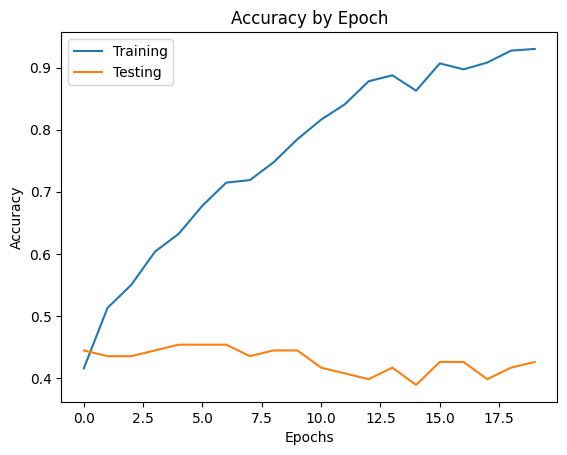

In [ ]:
#Plot Accuracy by Epoch
plt.plot(amodResult.history['accuracy'], label = 'Training')
plt.plot(amodResult.history['val_accuracy'], label = 'Testing')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy by Epoch')
plt.legend()
plt.show()

## Linear Regression Model

Before we leave, let's try that same data with a more simple linear regression model. Any improvement?

In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create and train the linear regression model
model = LinearRegression()
model.fit(ax_train, ay_train)

# Make predictions on the test set
ay_pred = model.predict(ax_test)

# Evaluate the model
mse = mean_squared_error(ay_test, ay_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.2742888773101046


In [ ]:
modelWins = 0
bookWins = 0
modelTotal = 0
bookTotal = 0

arrayIndex = 0
for index, row in dfAbTest.iterrows():
    # Compute bookmakers' odds for the match
    homePct = (1 / row['AvgH'])
    drawPct = (1 / row['AvgH'])
    awayPct = (1 / row['AvgH'])

    modelHome = ay_pred[arrayIndex][0]
    modelDraw = ay_pred[arrayIndex][1]
    modelAway = ay_pred[arrayIndex][2]

    if ay_test[arrayIndex][2] == 1:  # Home win
        if modelHome > homePct:
            modelWins += 1
            modelTotal += (modelHome - homePct)
        else:
            bookWins += 1
            bookTotal += (homePct - modelHome)

    if ay_test[arrayIndex][1] == 1:  # Draw
        if modelDraw > drawPct:
            modelWins += 1
            modelTotal += (modelDraw - drawPct)
        else:
            bookWins += 1
            bookTotal += (drawPct - modelDraw)

    if ay_test[arrayIndex][0] == 1:  # Away win
        if modelAway > awayPct:
            modelWins += 1
            modelTotal += (modelAway - awayPct)
        else:
            bookWins += 1
            bookTotal += (awayPct - modelAway)

    arrayIndex += 1

print(f"Model Wins: {modelWins}")
print(f"Bookie Wins: {bookWins}")
print(f"Model Total: {modelTotal}")
print(f"Bookie Total: {bookTotal}")

Model Wins: 43
Bookie Wins: 65
Model Total: 7.870449065388421
Bookie Total: 20.976892924439536


Yes, that linear regression model seems to perform at least as well as the deep learning that I tried.

Sanity Check. How do these models compare to random chance? To test, I'll install a package that generates random numbers that sum to a specific number. In this case, we want three numbers (percentages) that together equal one.

In [ ]:
!pip install drs

In [ ]:
from drs import drs
randomThree = drs(3, 1)
print(randomThree)
print(randomThree[0] + randomThree[1] + randomThree[2])


[0.3373216036663995, 0.15163153860600384, 0.5110468577275967]
1.0


In [ ]:
modelWins = 0
bookWins = 0
modelTotal = 0
bookTotal = 0

arrayIndex = 0
for index, row in dfAbTest.iterrows():
    # Compute bookmakers' odds for the match
    homePct = (1 / row['AvgH'])
    drawPct = (1 / row['AvgH'])
    awayPct = (1 / row['AvgH'])

    randomPred = drs(3, 1)
    modelHome = randomPred[0]
    modelDraw = randomPred[1]
    modelAway = randomPred[2]

    if ay_test[arrayIndex][2] == 1:  # Home win
        if modelHome > homePct:
            modelWins += 1
            modelTotal += (modelHome - homePct)
        else:
            bookWins += 1
            bookTotal += (homePct - modelHome)

    if ay_test[arrayIndex][1] == 1:  # Draw
        if modelDraw > drawPct:
            modelWins += 1
            modelTotal += (modelDraw - drawPct)
        else:
            bookWins += 1
            bookTotal += (drawPct - modelDraw)

    if ay_test[arrayIndex][0] == 1:  # Away win
        if modelAway > awayPct:
            modelWins += 1
            modelTotal += (modelAway - awayPct)
        else:
            bookWins += 1
            bookTotal += (awayPct - modelAway)

    arrayIndex += 1

print(f"Model Wins: {modelWins}")
print(f"Bookie Wins: {bookWins}")
print(f"Model Total: {modelTotal}")
print(f"Bookie Total: {bookTotal}")

Model Wins: 31
Bookie Wins: 77
Model Total: 6.3192865698832605
Bookie Total: 22.389075113020464


No, random chance did not outperform our models, so at least we've got that going for us.

![Buffalo Soccer Header](https://carload.com/g/BuffaloSoccerWide400.jpg)

## Conclusion
I am proudest of assembling and wrangling the data so that data scientists can quickly access the information for three previous weeks for both teams in each Bundesliga match. That CSV file is available in the same GitHub folder as this notebook.

On the other hand, the predictive classification models could have gone a lot better. If I'd had a few more weeks to construct and test more elaborate neural networks, or if I'd found a magic system of weights, the results could have been very different. I hope that someone else can pick up this information and improve on it.

For now, the Poisson prediction model remains unbeaten. I'll remember that next time I want to put down $2 on a Bundesliga match.